In [1]:
from cppbridge import *
from mcmc_analytics import *
plt.rcParams['font.size'] = '16'

In [2]:
%load_ext autoreload
%autoreload 2

# Checking Metropolitan and EHMM samplers with non-linear non-Gaussian models

The experiments are for the models and samplers presented in the paper\
[1] Shestopaloff A.Y, Neal R.M. Sampling Latent States for High-Dimensional Non-Linear State Space Models with the Embedded HMM Method

---
## Model specification

### Transition model  
For transition model we take the same VAR(1) model as with linear gaussian experiments.

In [3]:
# Set up the transition model with parameters above
T = 250
n = 10
A = DiagonalMatrixParam()
A.value = np.eye(n) * 0.9
Q = SymmetricMatrixParam()
Q.value = np.ones((n,n)) * 0.7 + np.eye(n) * 0.3
prior_mean = np.zeros(n)
Q_init = Q.value * (1/(1-0.9*0.9))
trm = TransitionSpec(A, Q, prior_mean, Q_init)

### Observation model
The observation mode l is Poisson generalized linear model

In [4]:
# Set up the Poisson observation model
C = DiagonalMatrixParam()
C.value = 0.6 * np.eye(n)
D = DiagonalMatrixParam()
D.value = -0.4 * np.eye(n)
u = ConstParam(np.ones(n))
obsm = ObservationSpec(ModelType.LINEAR_POISSON, C, D, u)

## Samplers specification
### Metropolis sampling scheme

In [5]:
# Specify metropolis scheme
met_sampler = SamplerSpec(SamplerType.METROPOLIS)

### Embedded HMM sampling scheme

In [6]:
# Specify EHMM schemes for both models
pool_sz = 50
ehmm_sampler = SamplerSpec(SamplerType.EHMM, pool_size=pool_sz)

## Observations 
We use the synthetic data generated in `models.ipynb` notebook.

In [7]:
# We use the data file generated previously
dg = DataGenerator(trm, obsm, T, 200434834)
datafile = f"{dg.modelhash}_data.h5"
dataspec = Data(datafile)

## Simulation
### Single-state Metropolis MCMC
To run the simulation we need to provide the initial sample $\mathbf{x}_0$ to start off the sampler, and specify the parameters of the simulation. We set $\mathbf{x}_0=\mathbf{0}$ for both schemes. We run 5 simulations for $10^6$ iterations each, starting with the different seed for randomisation. To save memory we thin the sampling, only recording each tenth sample.

In [8]:
n_iter_met = int(1e6)
seeds = np.array([1, 10, 100, 1e4, 1e5], dtype=int)
scales_met = np.array([0.2, 0.8])
thinning = 10
x_init = np.zeros((n, T))
simulation_met = SimulationSpec(n_iter_met, seeds, x_init, thinning=thinning, scaling=scales_met)

In [9]:
# Simulation with Metropolitan single state sampler
met_session_name = f"met_noreverse_{dg.modelhash}"
mcmc_met_lp = MCMCsession(met_session_name)
if mcmc_met_lp.hasResults():
    mcmc_met_lp.loadResults() # <-- NB! Each file is ~2GB so it takes time to download
else:
    mcmc_met_lp.init(T, trm, obsm, met_sampler, simulation_met, dataspec)
    mcmc_met_lp.run()

Loading results for seed10...		Done
Loading results for seed10000...		Done
Loading results for seed100000...		Done
Loading results for seed100...		Done
Loading results for seed1...		Done


### Embdedded HMM MCMC
For EHMM smapler we run 5 simulations for $10000$ iterations each, starting with the different seed for randomisation (we use the same seeds as for single state sampler). Each iteration will run on both original and reversed sequence of observations.

In [10]:
n_iter_ehmm = 10000
scales_ehmm = np.array([0.1, 0.5])
reverse = True
simulation_ehmm = SimulationSpec(n_iter_ehmm, seeds, x_init, scaling=scales_ehmm, reverse=reverse)

In [11]:
# Simulation with EHMM sampler
ehmm_session_name = f"ehmm50_reverse_{dg.modelhash}"
mcmc_ehmm_lp = MCMCsession(ehmm_session_name)
if mcmc_ehmm_lp.hasResults():
    mcmc_ehmm_lp.loadResults()
else:
    mcmc_ehmm_lp.init(T, trm, obsm, ehmm_sampler, simulation_ehmm, dataspec)
    mcmc_ehmm_lp.run()

Loading results for seed100000...		Done
Loading results for seed10000...		Done
Loading results for seed10...		Done
Loading results for seed100...		Done
Loading results for seed1...		Done


---
## Analysis of the results for Poisson model 1
### Overview

In [12]:
nsamples_met = n_iter_met//thinning + 1
nsamples_ehmm = (1 + reverse) * (n_iter_ehmm + 1)
met_burnin = int(0.1 * nsamples_met)
ehmm_burnin = int(0.1 * nsamples_ehmm)

met_samples = mcmc_met_lp.getSamples(met_burnin)
ehmm_samples = mcmc_ehmm_lp.getSamples(ehmm_burnin)

In [13]:
ac_ehmm = getACF(mcmc_ehmm_lp.samples, ehmm_samples, lags=nsamples_ehmm-1)
taus_ehmm = 1 + 2*np.sum(ac_ehmm, axis=2)
meantaus_ehmm = np.mean(taus_ehmm)

ac_met = getACF(mcmc_met_lp.samples, met_samples, lags=nsamples_met-1)
taus_met = 1 + 2*np.sum(ac_met, axis=2)
meantaus_met = np.mean(taus_met)

In [20]:
met_overview = {"Num seeds": len(seeds),
                "Num iter": n_iter_met,
                "Time per sample, ms": np.mean(list(mcmc_met_lp.durations.values()))/list(mcmc_met_lp.samples.values())[0].shape[0],
                "Acceptance rate, %": 100 * np.mean(list(mcmc_met_lp.acceptances.values()))/n_iter_met,
                "Average autocorrelation time": meantaus_met
                }

ehmm_met_acc = 100 * np.mean([acc[:T].mean() / (n_iter_ehmm * pool_sz * (1 + reverse)) for _, acc in mcmc_ehmm_lp.acceptances.items()])
ehmm_shift_acc = 100 * np.mean([acc[T+1:].mean() / (n_iter_ehmm * pool_sz * (1 + reverse)) for _, acc in mcmc_ehmm_lp.acceptances.items()])
ehmm_overview = {"Num seeds": len(seeds),
                 "Num iter": n_iter_ehmm,
                 "Time per sample, ms": np.mean(list(mcmc_ehmm_lp.durations.values()))/list(mcmc_ehmm_lp.samples.values())[0].shape[0],
                 "Acceptance rate, %": (ehmm_met_acc, ehmm_shift_acc),
                 "Average autocorrelation time": meantaus_ehmm
                 }
overview = pd.DataFrame({"Single-state Metropolis":met_overview, "Embedded HMM":ehmm_overview}).T
overview['Average autocorrelation time'] *= overview['Time per sample, ms']
overview

,Num seeds,Num iter,"Time per sample, ms","Acceptance rate, %",Average autocorrelation time
Single-state Metropolis,5.0,1000000.0,6.394324,73.541118,78.582462
Embedded HMM,5,10000,39.752145,"(77.13058656, 50.82595863453816)",290.8257


In [33]:
met_ar = np.array(list(mcmc_met_lp.acceptances.values())).ravel() / n_iter_met
ehmm_ar = np.stack(list(mcmc_ehmm_lp.acceptances.values()), axis=1)[:T].ravel() / (n_iter_ehmm * pool_sz * (1 + reverse))
ehmm_shift = np.stack(list(mcmc_ehmm_lp.acceptances.values()), axis=1)[T+1:].ravel() / (n_iter_ehmm * pool_sz * (1 + reverse))
pd.DataFrame(dict(met_ar=met_ar, ehmm_ar=ehmm_ar, ehmm_shift=np.append(ehmm_shift, [np.nan]*len(seeds)))).describe()

,met_ar,ehmm_ar,ehmm_shift
count,1250.000000,1250.000000,1245.000000
mean,0.735411,0.771306,0.508260
std,0.122703,0.083748,0.101394
min,0.371637,0.440282,0.180204
25%,0.651421,0.730437,0.429080
50%,0.756263,0.788674,0.516278
75%,0.831627,0.834954,0.587741
max,0.936941,0.899422,0.693268


In [34]:
overview.to_latex(OUTPUTS_PATH/"overview_lp.tex", column_format="rrrrrr", escape=True, caption="Overview of the two samplers")

/var/folders/cj/vfqx8gc938b8xyvdtnybphkr0000gn/T/ipykernel_8729/355515877.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  overview.to_latex(OUTPUTS_PATH/"overview_lp.tex", column_format="rrrrrr", escape=True, caption="Overview of the two samplers")


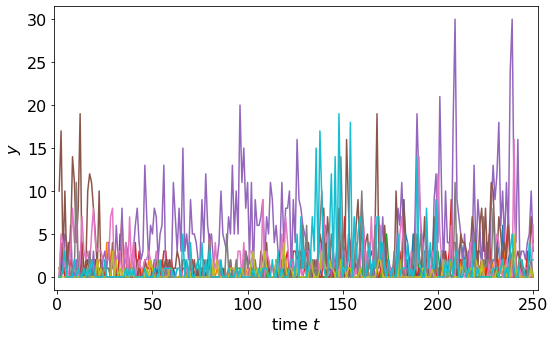

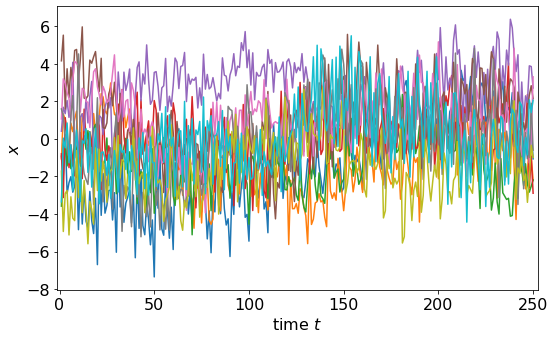

In [14]:
# Plot the observations for all dimensions across time
xs = np.array(range(1, T+1))
for name, series in {"y":dg.observations, "x":dg.states}.items():
    fig, ax = plt.subplots(figsize=(8,5))
    for i in range(n):
        ax.plot(xs, series[i, :], color=f'C{i}')
    ax.set_xmargin(0.01)
    ax.set_xlabel("time $t$")
    ax.set_ylabel(f"${{{name}}}$")
    plt.tight_layout()
    plt.savefig(OUTPUTS_PATH/f"generated_lp_{name}s.png", dpi=150, format='png')
    plt.show();

### Convergence analysis

In [15]:
epsr = getEPSR(mcmc_ehmm_lp.samples, ehmm_burnin)

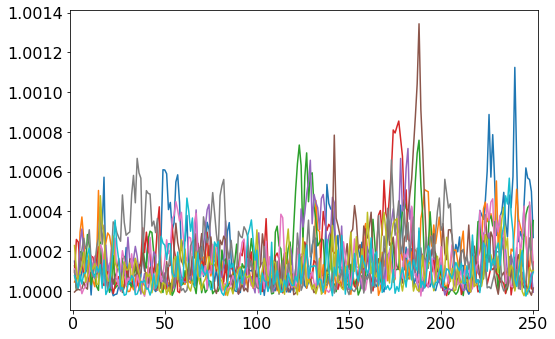

In [16]:
fig, ax = plt.subplots(figsize=(8,5))
xs = np.array(range(1, T+1))
for i in range(n):
    ax.plot(xs, epsr[:, i])
ax.set_xmargin(0.01)
plt.tight_layout()
plt.savefig(OUTPUTS_PATH/"epsr_ehmm_lp.png", dpi=150, format='png')
plt.show();

In [17]:
epsr_met = getEPSR(mcmc_met_lp.samples, met_burnin)

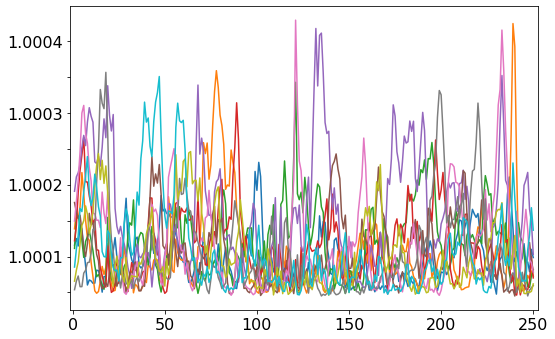

In [18]:
from matplotlib.ticker import FormatStrFormatter
fig, ax = plt.subplots(figsize=(8,5))
xs = np.array(range(1, T+1))
for i in range(n):
    ax.plot(xs, epsr_met[:, i])
ax.set_xmargin(0.01)
ax.locator_params(axis='y', nbins=10)
ax.yaxis.set_major_formatter(FormatStrFormatter('%.4f'))
for i, tick in enumerate(ax.yaxis.get_ticklabels()):
    if i % 2 != 0:
        tick.set_visible(False) 
plt.tight_layout()
plt.savefig(OUTPUTS_PATH/"epsr_met_lp.png", dpi=150, format='png')
plt.show();

### Autocorrelation analysis

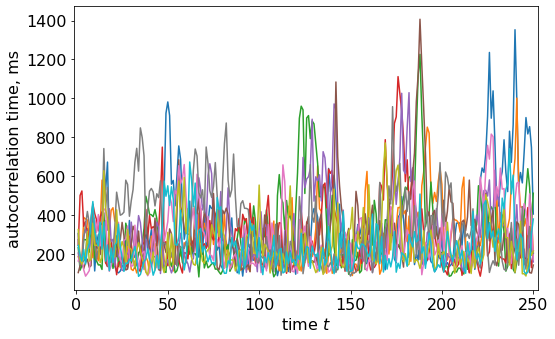

In [21]:
fig, ax = plt.subplots(figsize=(8,5))
xs = np.array(range(1, T+1))
for i in range(n):
    ax.plot(xs, taus_ehmm[i, :]*overview.loc['Embedded HMM', 'Time per sample, ms'])
ax.set_xmargin(0.01)
ax.set_xlabel("time $t$")
ax.set_ylabel("autocorrelation time, ms")
plt.tight_layout()
plt.savefig(OUTPUTS_PATH/"taus_ehmm_lp.png", dpi=150, format='png')
plt.show();

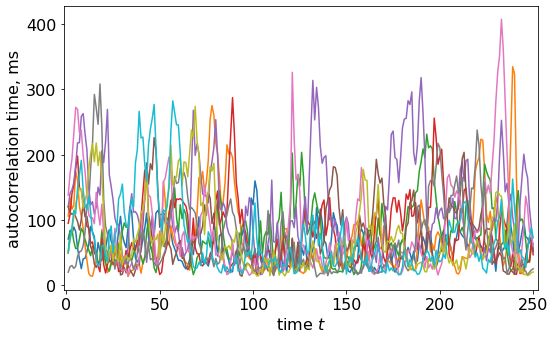

In [22]:
fig, ax = plt.subplots(figsize=(8,5))
xs = np.array(range(1, T+1))
for i in range(n):
    ax.plot(xs, taus_met[i, :]*overview.loc['Single-state Metropolis', 'Time per sample, ms'])
ax.set_xmargin(0.01)
ax.set_xlabel("time $t$")
ax.set_ylabel("autocorrelation time, ms")
plt.tight_layout()
plt.savefig(OUTPUTS_PATH/"taus_met_lp.png", dpi=150, format='png')
plt.show();

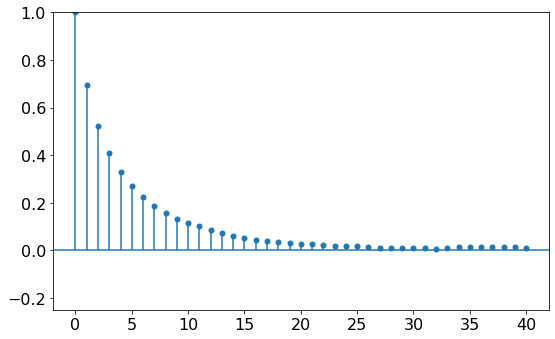

In [23]:
fig, ax = plt.subplots(figsize=(8,5))
plotACF(ac_ehmm, 125, 2, ax, nlags=40)
ax.set_ylim(-0.25,1)
plt.tight_layout()
plt.savefig(OUTPUTS_PATH/"acf_ehmm_125-2_lp.png", dpi=150, format='png')
plt.show();

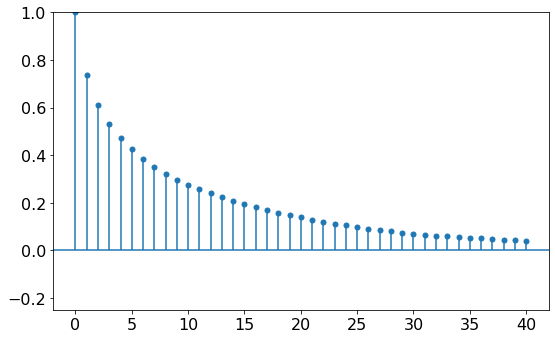

In [24]:
fig, ax = plt.subplots(figsize=(8,5))
plotACF(ac_met, 125, 2, ax, nlags=40)
ax.set_ylim(-0.25,1)
plt.tight_layout()
plt.savefig(OUTPUTS_PATH/"acf_met_125-2_lp.png", dpi=150, format='png')
plt.show();

### Trace plots

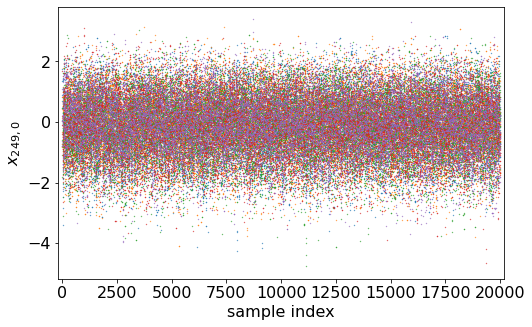

In [25]:
# Check mixing of different seeds
plotMixing(mcmc_ehmm_lp.samples, 249, 0, save="ehmm_lp")

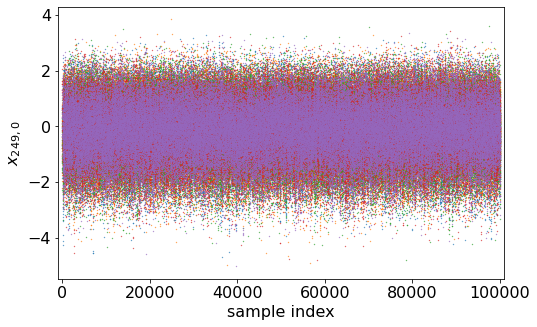

In [26]:
plotMixing(mcmc_met_lp.samples, 249, 0, save="met_lp")

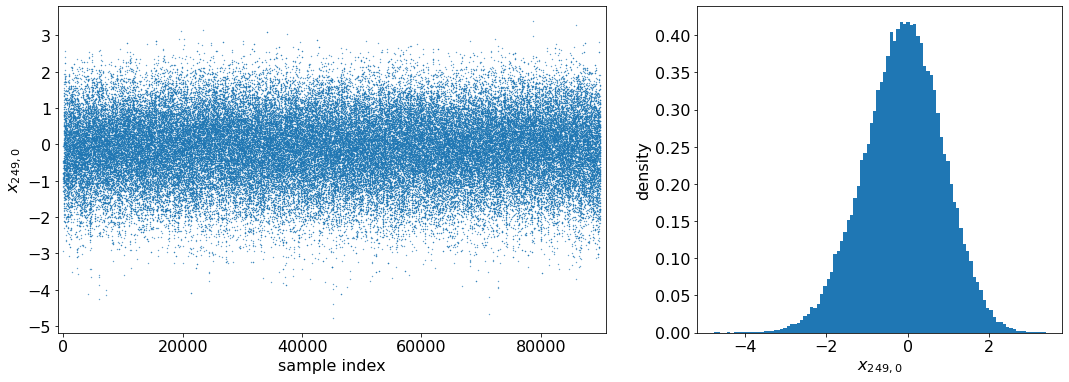

{}

In [27]:
# Trace plots of a couple of particles
plotTrace(ehmm_samples, 249, 0, save="ehmm_lp", hbins=100)

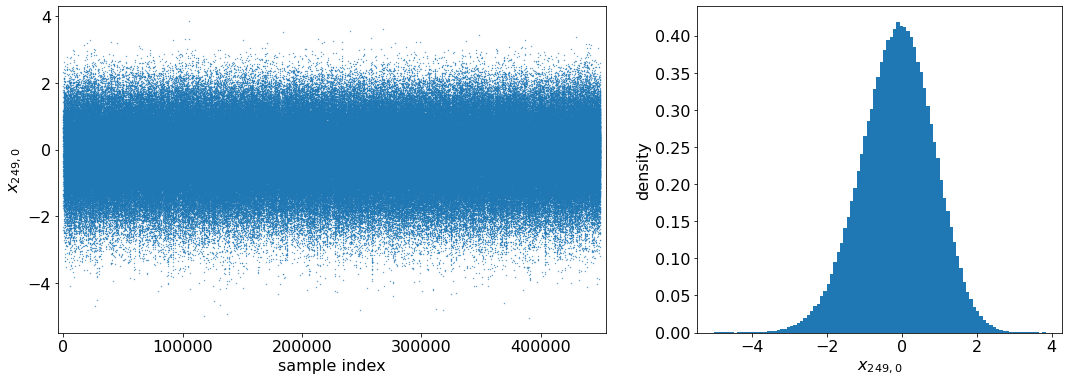

{}

In [28]:
plotTrace(met_samples, 249, 0, save="met_lp", hbins=100)